In [1]:
# Dependancies
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from datetime import datetime

c:\Users\billo\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\billo\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\billo\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Define the model

In our implementations, 
- $n$ is the number of observations $y = (y_1, ..., y_n)$. $y_i | \theta_i \sim F(\theta) = N(\theta, \tau)$ where $\tau$ is fixed. The prior on the $\theta_i$ is of the form $G_0 = N(0,1)$. 
- $c = (c_1, ..., c_n)$ is a list of integers, where $c_i$ is the cluster of observation $i$
- $\phi$ or $\theta$ depending of the algorithms is a list where $\phi_i$ is the mean of the cluster $c_i$




### General Case

In [53]:
tau = 0.2
alpha = 0.25

In [54]:
# G0 is a normal distribution with mean 0 and variance 1
def g0_sampler():
    return np.random.normal(0, 1)

# f is a normal distribution with mean theta and variance tau
def f_sampler(theta):
    return np.random.normal(theta, tau)

# F(x, theta) evaluates F (normal distribution) in x
def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * tau**2))

def F_loglikelihood(theta, x):
    return -(theta - x)**2 / (2 * tau**2)

In [55]:
def g0_logdensity(theta):
    return -theta**2 / 2 - np.log(np.sqrt(2 * np.pi))

Assume $x_i \mid \mu \sim \mathcal{N}\left(\mu = \theta, \sigma^2 = \tau\right)$ i.i.d.and $\mu \sim \mathcal{N}\left(\mu_0 = 0, \sigma_0^2 = 1\right)$. Then:
$$
\mu \mid x_{c1}, x_{c2}, \cdots, x_{ck} \sim \mathcal{N}\left(\frac{\sigma_0^2}{\frac{\sigma^2}{n}+\sigma_0^2} \overline{x_c}+\frac{\sigma^2}{\frac{\sigma^2}{n}+\sigma_0^2} \mu_0,\left(\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\right)^{-1}\right)
$$

In [56]:
def posterior(y):
    mean = np.mean(y)
    number = len(y)
    return np.random.normal((1+ tau/number)*mean, 1/(1+ number/tau))

### Dirichlet process

In [57]:
def DP_loglikelihood(thetas):
    lh = 0
    for i, theta in enumerate(thetas):
        if theta in thetas[:i]:
            lh += np.log(np.sum(thetas[:i] == theta) / (i + alpha))
        else:
            lh += np.log(alpha / (i + alpha)) + g0_logdensity(theta)
    return lh

In [58]:
def DP_sampler(n):
    """
    This function samples n thetas from a Dirichlet Process of parameter alpha
    and base distribution G0
    """
    # Sample the thetas
    thetas = []
    for i in range(n):
        u = np.random.uniform()
        if u < alpha / (alpha + i):
            thetas.append(g0_sampler())
        else:
            thetas.append(thetas[np.random.randint(0, i)])
    return thetas

### Auxilary functions

In [59]:
def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")

def update_cluster_phis(c, phi, y):
    for c_unique in np.unique(c):
        phi[c_unique] = np.mean(y[c == c_unique])


#### Auxilary functions for the conjugate prior case (Algorithms 1, 2, 3)

In [60]:
def Hi_sampler(y):
    m = (y / tau**2) / (1 / tau**2 + 1 / 1**2)
    s = 1 / (1 / tau**2 + 1 / 1**2)
    return np.random.normal(m, s)

def ri_integral(y):
    return tau * np.exp(-y**2 / (2 + 2 * tau**2)) / np.sqrt(tau**2 + 1)

### Generate Data

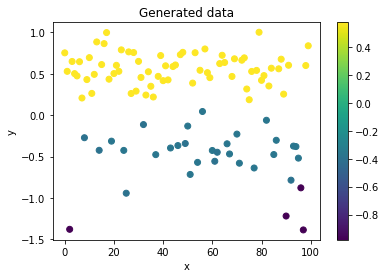

In [61]:
# Generate data
n = 100
thetas = DP_sampler(n)
y = np.array([f_sampler(theta) for theta in thetas])

# Plot data
plt.figure()
plt.scatter(np.arange(n), y, c=thetas)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

In [69]:
y = np.array([-0.3256188 , -0.43092995,  1.60089869,  1.80794025, -0.23496168,
        2.22528021, -0.41624213, -0.2915612 , -0.52381541, -0.51177656,
       -0.65748387,  1.58592953, -0.4750672 ,  1.74415777, -0.00440874,
        1.47447673, -0.39477349, -0.41031549,  0.0649048 , -0.34165361,
       -0.12707548,  1.57536289, -0.55966975, -0.3794802 ,  1.99659421,
        2.12495612, -0.65394037,  1.5379578 , -0.23478165, -0.33167543,
        1.47685422, -0.25004367,  1.78212218, -0.45731061,  1.38308488,
        1.88843163,  1.50594422, -0.27256526, -0.71413434, -0.72292323,
        1.89199991,  1.82468791, -0.31301438,  2.08910457,  2.04863437,
        2.22805643,  1.6256737 , -0.11244296,  1.74405149,  1.63885817,
       -0.18896373,  2.02685373, -0.67696542,  1.90177644, -0.22765228,
       -0.49304382,  1.84345641,  1.78513511,  1.787267  ,  1.83192619,
       -0.30702378,  1.926645  ,  2.02899633, -0.443003  , -0.61737759,
       -0.27819684, -0.34121134, -0.79604005,  1.75253447,  1.56055199,
       -0.28329314,  2.0233593 , -0.50098222,  1.67228192, -0.18476536,
       -0.55037805, -0.374823  , -0.34098955,  1.84975783,  1.77908043,
        1.87272933,  2.22590325, -0.5551349 , -0.57476731, -0.17715395,
       -0.39921745,  1.55985138,  1.88851503,  1.71074307,  1.87987111,
        2.01673192, -0.55740399,  1.86515774,  1.75052161,  1.77981471,
       -0.33884651, -0.36026426,  1.60227771,  1.96343786, -0.61051141])

### Run algorithm function (not functional)

In [ ]:
def run_algorithm(algorithm, N, y):
    """"
    Run algorithm N times (n_iter) and plot evolution of log_likelyhood, theta and cluster assignments
    """"
    # Run algorithm
    start_time =  datetime.now()
    cs, thetas, lhs = algorithm(N, y)
    end_time = datetime.now()

    print(f"Time per interation: {(end_time - start_time) / N:.6f} seconds")

    complete_llhs = np.zeros((N+1), dtype=float)
    for i in range(N+1):
        complete_llhs[i] = F_loglikelihood(thetas[i], y).sum() + DP_loglikelihood(thetas[i])

    # Plot results
    plt.figure()
    plt.scatter(np.arange(n), y, c=thetas[N])
    plt.title("Generated data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()
    plt.figure()

    # define infinite list of colors
    COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for i, cluster in enumerate(np.unique(thetas[-1])):
        color = next(COLORS)
        plt.scatter(np.arange(n)[thetas[-1] == cluster], y[thetas[-1] == cluster], label=i, color=color)
        plt.axhline(cluster, color=color)
    plt.title("Generated data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    # Plot evolution of log likelihood
    plt.figure()
    plt.plot(np.arange(N+1), complete_llhs)
    plt.title("Log likelihood")
    plt.xlabel("Iteration")
    plt.ylabel("Log likelihood")
    plt.show()

    # plot evolution of theta
    plt.figure()
    it_list = []
    phi_list = []
    size_list = []
    for it in range(0, N+1):
        phis_counts = np.unique(thetas[it], return_counts=True)
        phi_list.extend(phis_counts[0])
        it_list.extend([it] * len(phis_counts[0]))
        size_list.extend(phis_counts[1])

    plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
    plt.title("Cluster assignments")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster mean")
    plt.colorbar()
    plt.show()


# Algorithms

### Algorithm 1

In [27]:
def algorithm_1(N, y):
    # Initialize
    n = len(y)
    thetas = np.zeros((N+1, n), dtype=float)
    # cs is unused #
    cs = np.zeros((N+1, n), dtype=int)

    # Loop over data
    for i in range(1, N+1):
        theta = thetas[i-1].copy()

        # Perform Gibbs sampling
        for j in range(n):
            lh_proposals = np.zeros(n, dtype=float)
            for theta_unique in np.unique(theta):
                lh_proposals[theta == theta_unique] = F_likelihood(theta_unique, y[j])
            lh_proposals[j] = alpha * ri_integral(y[j])

            # Sample j
            j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
            if j_proposal == j:
                theta[j] = Hi_sampler(y[j])
            else:
                theta[j] = theta[j_proposal]

        thetas[i] = theta

    return cs, thetas

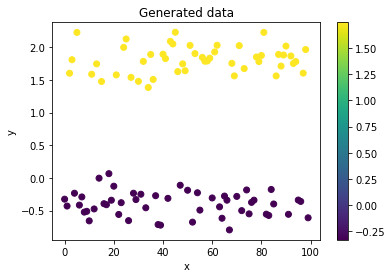

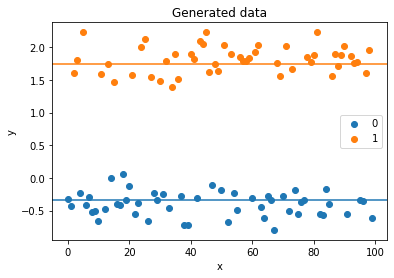

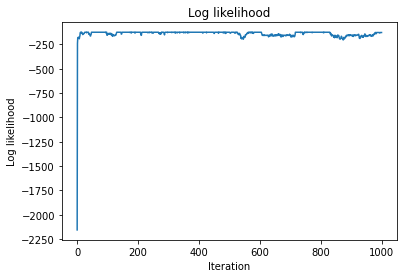

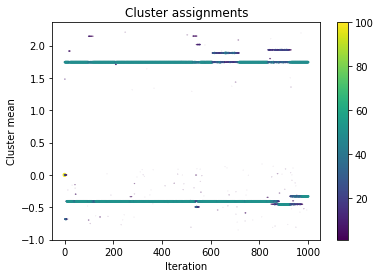

In [29]:
# Run algorithm
N = 1000
cs, thetas = algorithm_1(N, y)

complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(thetas[i], y).sum() + DP_loglikelihood(thetas[i])

# Plot results
plt.figure()
plt.scatter(np.arange(n), y, c=thetas[N])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

plt.figure()
# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(thetas[-1])):
    color = next(COLORS)
    plt.scatter(np.arange(n)[thetas[-1] == cluster], y[thetas[-1] == cluster], label=i, color=color)
    plt.axhline(cluster, color=color)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Plot evolution of log likelihood
plt.figure()
plt.plot(np.arange(N+1), complete_llhs)
plt.title("Log likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(thetas[it], return_counts=True)
    phi_list.extend(phis_counts[0])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()


## Algorithm 2

In [25]:
def algorithm_2(n_iters, y, alpha):
    n = len(y)
    phis = np.zeros((n_iters+1, n), dtype=float)
    cs = np.zeros((n_iters+1, n), dtype=int)

    for iter in range(1, n_iters+1):
        phi = phis[iter-1].copy() 
        c = cs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)

            
            # Remove phi_ci from the state and draw a new value for ci from eq 3.6
            new_parameter_prob = alpha / (n - 1 + alpha) * ri_integral(y[ii])
            old_parameter_prob = 1 / (n - 1 + alpha) * F_likelihood(phi[c_unique], y[ii])
            # Sampling probabilities for all [old params , new param] 
            sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
            # Normalize to get a probability distribution
            sampling_prob /= np.sum(sampling_prob)
            # Choose cluster with probability sampling_prob
            # The new cluster replaces an unused cluster
            if np.sum(c == c[ii]) == 1:
                ci_star = np.random.choice(np.append(c_unique, c[ii]), p=sampling_prob)
            else:
                ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
            c[ii] = ci_star
            if np.sum(ci_star == c) == 1:
                phi[ci_star] = Hi_sampler(y[c == ci_star])
            
        
        for c_unique in np.unique(c):
            phi[c_unique] = posterior(y[c == c_unique])
    
        cs[iter] = c.copy()
        phis[iter] = phi.copy()

    return cs, phis


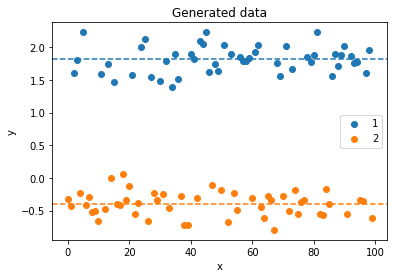

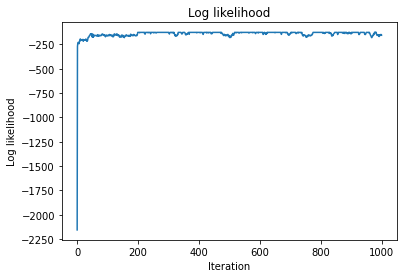

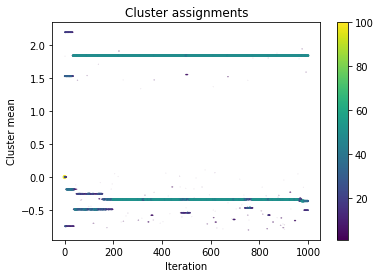

In [26]:
# Run algorithm 2
data = y
n = len(data)
N = 1000
alpha = 0.25

cs, phis = algorithm_2(N, data, alpha)
c = cs[-1]
phi = phis[-1]


complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(thetas[i], y).sum() + DP_loglikelihood(thetas[i])


plt.figure()
# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(c)):
    color = next(COLORS)
    plt.scatter(np.arange(n)[c == cluster], data[c == cluster], label=cluster, color=color)
    plt.axhline(phi[cluster], color=color, linestyle="--")
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Plot evolution of log likelihood
plt.figure()
plt.plot(np.arange(N+1), complete_llhs)
plt.title("Log likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(thetas[it], return_counts=True)
    phi_list.extend(phis_counts[0])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()


## Algorithm 4

In [31]:
def algorithm_4(N, y):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()

        for j in range(n):
            k = len(np.unique(c[np.arange(n) != j]))
            c_proposal = find_unused_cluster(c)

            if np.sum(c == c[j]) == 1:
                if np.random.uniform() < 1 / (k + 1):
                    c[j] = c_proposal
                    phi[c[j]] = g0_sampler()
            
            else:
                phi_proposal = g0_sampler()
                lh_proposals = np.zeros(n)
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])

                lh_proposals[j] = (alpha / (k + 1)) * F_likelihood(phi_proposal, y[j]) 

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))

                if j_proposal == j:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                else:
                    c[j] = c[j_proposal]

        update_cluster_phis(c, phi, y)
            
        cs[i] = c
        phis[i] = phi

    return cs, phis

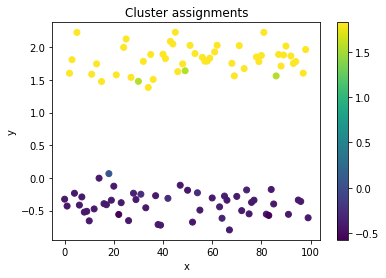

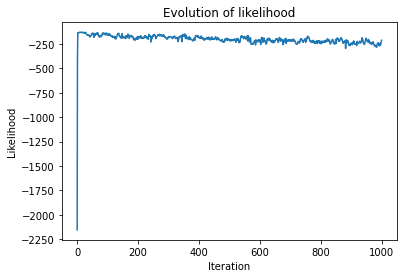

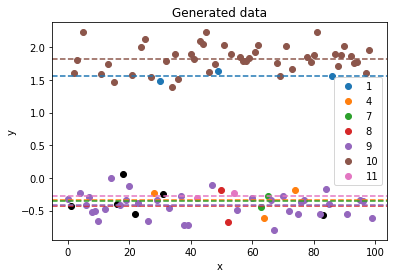

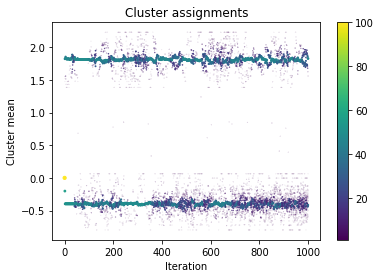

In [32]:
# Run algorithm
N = 1000
cs, phis = algorithm_4(N, y)

complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(phis[i, cs[i]], y).sum() + DP_loglikelihood(phis[i, cs[i]])

# Plot results
plt.figure()
plt.scatter(np.arange(n), y, c=phis[N, cs[N]])
plt.title("Cluster assignments")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(complete_llhs)
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

plt.figure()
# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(cs[-1])):
    if np.sum(cs[-1] == cluster) == 1:
        plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], color="black")
    else:
        color = next(COLORS)
        plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], label=i, color=color)
        plt.axhline(phis[-1, cluster], color=color, linestyle="--")
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(cs[it], return_counts=True)
    phi_list.extend(phis[it][phis_counts[0]])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()

## Algorithm 5

In [62]:
def algorithm_5_sampler(alpha, c_unique, c_count, c, n):
        # Draw a candidate phi_i_star from Eq 5.4
        new_parameter_prob = alpha / (n - 1 + alpha)
        old_parameter_prob = 1 / (n - 1 + alpha)
        # Sampling probabilities for all [old params , new param] and normalize to get a probability distribution
        sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
        sampling_prob /= np.sum(sampling_prob)
        # Choose cluster with probability sampling_prob
        # The new cluster replaces an unused cluster
        ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
        return ci_star

In [63]:
def algorithm_5(n_iters, y, alpha):
    n = len(y)
    cs = np.zeros((n_iters+1, n), dtype=int)
    phis = np.zeros((n_iters+1, n), dtype=float)
    lhs = np.zeros((n_iters+1, n), dtype=float)

    for iter in range(1,n_iters+1):
        c = cs[iter-1].copy()
        phi = phis[iter-1].copy()
        lh = lhs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)
            # Sample a ci_star from Eq 5.4
            ci_star = algorithm_5_sampler(alpha, c_unique, c_count, c, n)

            # If the sampled index is the last one, we sample from G0
            if ci_star == len(c_unique):
                phi_proposal = g0_sampler()
            else: # Else we use an existing cluster
                phi_proposal = phi[ci_star]
            
            lh_proposal = F_likelihood(phi_proposal, y[ii])

            # Compute acceptance probability
            acceptance_prob = min(1, lh_proposal / lh[ii])

            # Accept or reject
            if np.random.rand() < acceptance_prob:
                c[ii] = ci_star
                phi[c[ii]] = phi_proposal
                lh[ii] = lh_proposal
        


        for c_unique in np.unique(c):
            phi[c_unique] = np.random.normal(np.mean(y[c == c_unique]), 0.01)

        cs[iter] = c.copy()
        phis[iter] = phi.copy()
        lhs[iter] = lh.copy()

    
    return cs, phis
   

C:\Users\billo\AppData\Local\Temp\ipykernel_16984\4057747746.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


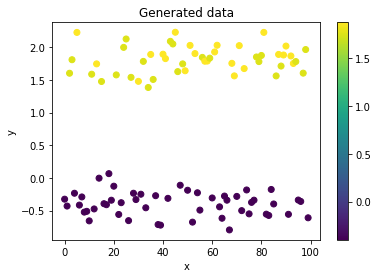

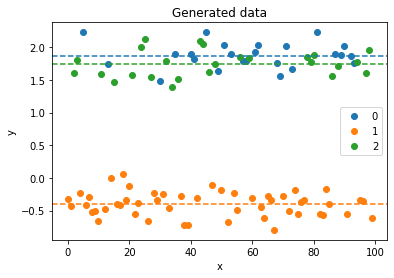

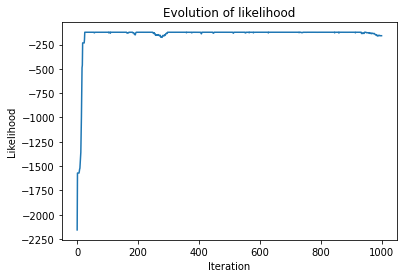

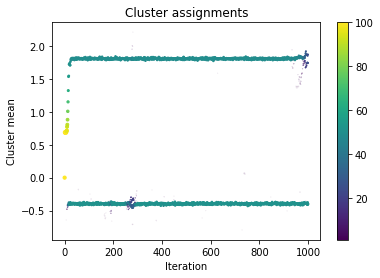

In [80]:
# Run algorithm 7
n = 100
N = 1000
alpha = 0.25

cs, phis = algorithm_5(N, y, alpha)
c = cs[-1]
phi = phis[-1]

complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(phis[i, cs[i]], y).sum() + DP_loglikelihood(phis[i, cs[i]])

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=phi[c])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()
plt.figure()

# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(cs[-1])):
    if np.sum(cs[-1] == cluster) == 1:
        plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], color="black")
    else:
        color = next(COLORS)
        plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], label=i, color=color)
        plt.axhline(phis[-1, cluster], color=color, linestyle="--")
        
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(complete_llhs)
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(cs[it], return_counts=True)
    phi_list.extend(phis[it][phis_counts[0]])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()

## Algorithm 6

In [123]:
def algorithm_6_sample(theta):
    # Choose wether we sample from existing theta or from g0
    if np.random.rand() < alpha / (len(theta) + alpha):
        # Sample from g0
        theta = g0_sampler()
    else:
        # Sample from existing theta
        theta = np.random.choice(theta)

    return theta

def algorithm_6(N, y):
    n = len(y)
    thetas = np.zeros((N+1, n))
    lhs = np.zeros((N+1, n))
    lhs[0] = np.array([F_likelihood(thetas[0, j], y[j]) for j in range(n)])

    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        lh = lhs[i-1].copy()
        for j in range(n):
            theta_proposal = algorithm_6_sample(theta[np.arange(n) != j])
            lh_proposal = F_likelihood(theta_proposal, y[j])

            # Compute acceptance probability
            a = min(1, lh_proposal / lh[j])

            # Accept or reject
            if np.random.rand() < a:
                theta[j] = theta_proposal
                lh[j] = lh_proposal
            
        thetas[i] = theta
        lhs[i] = lh

    return thetas, lhs


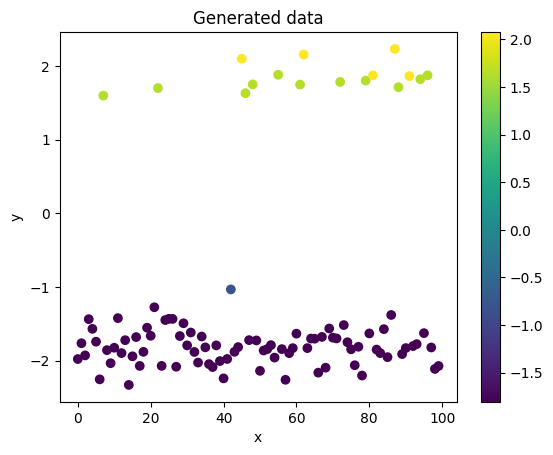

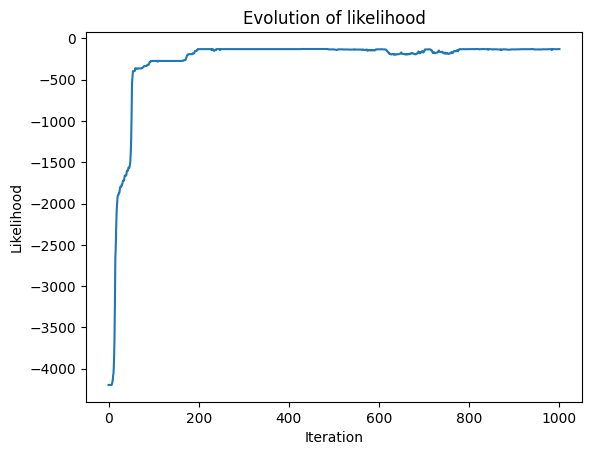

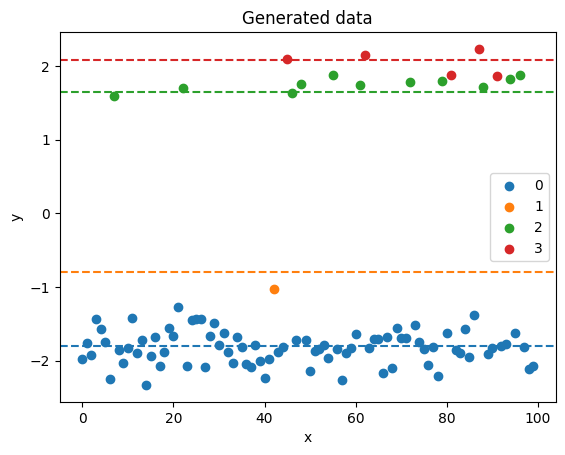

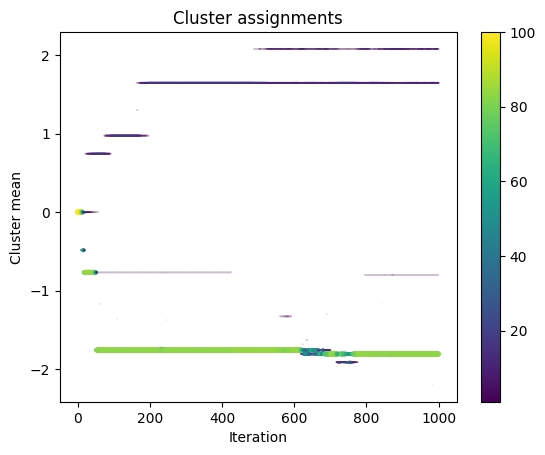

In [124]:
n = 100
N = 1000
alpha = 0.25

thetas, lhs = algorithm_6(N, y)
theta = thetas[-1]

complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(thetas[i], y).sum() + DP_loglikelihood(thetas[i])

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=theta)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(complete_llhs)
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

plt.figure()
# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(thetas[-1])):
    color = next(COLORS)
    plt.scatter(np.arange(n)[thetas[-1] == cluster], y[thetas[-1] == cluster], label=i, color=color)
    plt.axhline(cluster, color=color, linestyle="--")
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(thetas[it], return_counts=True)
    phi_list.extend(phis_counts[0])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()

## Algorithm 7

In [125]:
def algorithm_7(N, y):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(phis[0, j], y[j]) for j in range(len(y))])

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            # test if c[j] is a singleton
            if np.sum(c == c[j]) == 1:
                # Choose c[j] from c[-j] with probability n_i / (n - 1)
                c_proposal = np.random.choice(c[c != c[j]])
                lh_proposal = F_likelihood(phi[c_proposal], y[j])

                # Compute acceptance probability
                a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi[c_proposal]
                    lh[j] = lh_proposal

            else:
                c_proposal = find_unused_cluster(c)
                phi_proposal = g0_sampler()
                lh_proposal = F_likelihood(phi_proposal, y[j])

                # Compute acceptance probability
                a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposal

        for j in range(n):
            # test if c[j] is not a singleton
            if np.sum(c == c[j]) > 1:

                # Compute transition probas
                lh_proposals = np.zeros(len(c))
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])
                lh_proposals[j] = 0

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
                c[j] = c[j_proposal]
                lh[j] = lh_proposals[j_proposal]

        update_cluster_phis(c, phi, lh, y)  

        cs[i] = c
        phis[i] = phi
        lhs[i] = lh

    return cs, phis, lhs

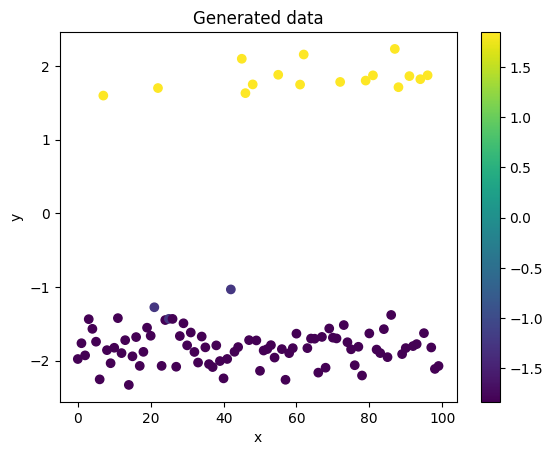

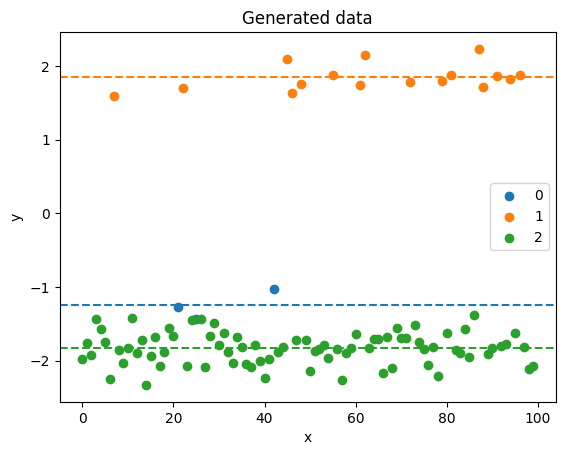

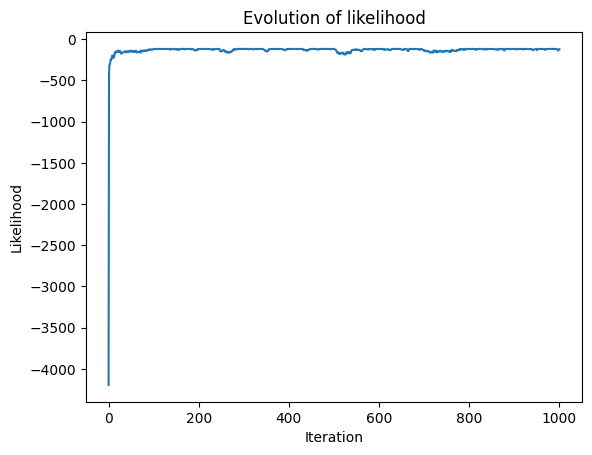

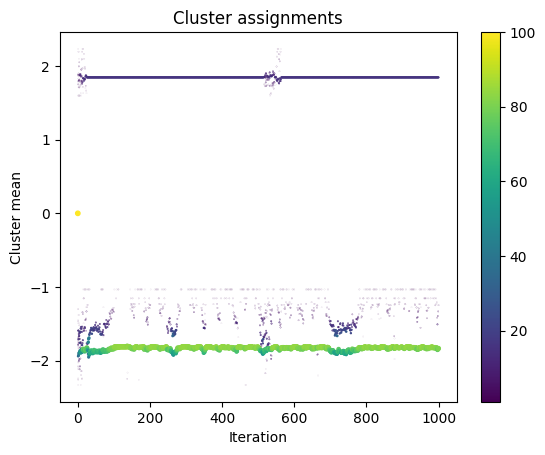

In [126]:
# Run algorithm 7
n = 100
N = 1000
alpha = 0.25

cs, phis, lhs = algorithm_7(N, y)
c = cs[-1]
phi = phis[-1]

complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(phis[i, cs[i]], y).sum() + DP_loglikelihood(phis[i, cs[i]])

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=phi[c])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()
plt.figure()

# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(cs[-1])):
    if np.sum(cs[-1] == cluster) == 1:
        plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], color="black")
    else:
        color = next(COLORS)
        plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], label=i, color=color)
        plt.axhline(phis[-1, cluster], color=color, linestyle="--")
        
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(complete_llhs)
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(cs[it], return_counts=True)
    phi_list.extend(phis[it][phis_counts[0]])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()

## Algorithm 8

In [70]:
def algorithm_8(y, N, alpha, m):
    n = len(y)
    phi_table = np.zeros((N+1, n + m), dtype=float)
    c_table = np.zeros((N+1, n), dtype=int)
    c_table[0] = np.array([i + 1 for i in range(n)])

    for loop in range(N):
        c = c_table[loop].copy()
        phi = phi_table[loop].copy()
        for i in range(n):
            c_minus_i = np.concatenate((c[:i], c[i + 1:]))
            k_ = np.unique(c_minus_i).size
            if c[i] in c_minus_i:
                phi[-m:] = np.array([g0_sampler() for _ in range(m)])
            else:
                phi[-m + 1:] = np.array([g0_sampler() for _ in range(m - 1)])
            probabilities = []
            for cluster in range(1, n + m + 1):
                if cluster <= n:
                    n_occurence = np.sum(c_minus_i == cluster)
                    probabilities.append(n_occurence / (n - 1 + alpha) * F_likelihood(phi[cluster - 1], y[i]))
                else:
                    probabilities.append((alpha / m) / (n - 1 + alpha) * F_likelihood(phi[cluster - 1], y[i])) 
            probabilities = np.array(probabilities)
            probabilities_without_nan = np.nan_to_num(probabilities, nan=0)
            sum_prob_without_nan = np.sum(probabilities_without_nan)
            if sum_prob_without_nan == 0:
                c[i] = np.random.choice(np.array([i + 1 for i in range(n + m)]))
            else:
                probabilities /= sum_prob_without_nan
                c[i] = np.random.choice(np.array([i + 1 for i in range(n + m)]), p=probabilities)
        for cluster in np.unique(c):
            phi[cluster - 1] = np.mean(y[c == cluster])
        phi_table[loop + 1] = phi
        c_table[loop + 1] = c

    return c_table, phi_table

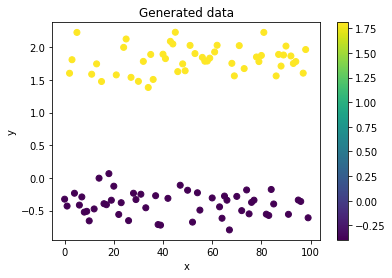

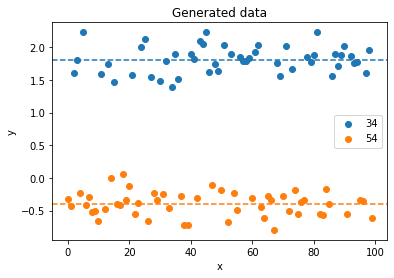

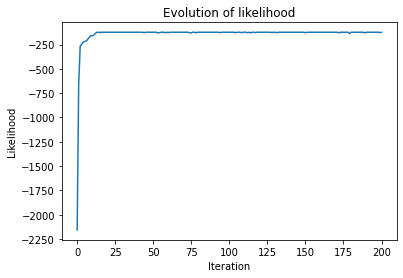

<Figure size 432x288 with 0 Axes>

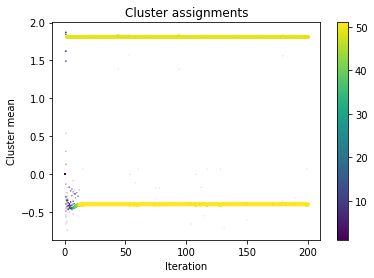

In [76]:
N = 200
alpha = 0.25
m = 5

cs, phis = algorithm_8(y, N, alpha, m)
c = cs[-1]
phi = phis[-1]

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=phi[c - 1])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot y coloured by theta
plt.figure()
# define infinite list of colors
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, cluster in enumerate(np.unique(c)):
    plt.scatter(np.arange(n)[c == cluster], y[c == cluster], label=cluster, color=COLORS[i])
    plt.axhline(phi[cluster - 1], color=COLORS[i], linestyle="--")
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

complete_llhs = np.zeros((N+1), dtype=float)
for i in range(N+1):
    complete_llhs[i] = F_loglikelihood(phis[i, cs[i]- 1], y).sum() + DP_loglikelihood(phis[i, cs[i] - 1])

# plot evolution of lh
plt.figure()
plt.plot(complete_llhs)
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()
plt.figure()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(cs[it] - 1, return_counts=True)
    phi_list.extend(phis[it][phis_counts[0]])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()